## Importation des données

In [1]:
import pandas
import numpy as np

In [2]:
raw = pandas.read_excel('filtered_data.xlsx')

In [3]:
raw.columns

Index(['Last Name', 'First Name', 'Position', 'GP', 'G', 'A', 'A1', 'PTS',
       '+/-', 'IPP%', 'TOI/GP', 'iCF', 'iFF', 'iSF', 'iSCF', 'iHDCF', 'iRush',
       'iReb', 'Pass', 'ZS%', 'iGVA', 'iTKA', 'iBLK', 'S.Bkhd', 'S.Dflct',
       'S.Slap', 'S.Snap', 'S.Tip', 'S.Wrap', 'S.Wrst', 'CF', 'CA', 'FF', 'FA',
       'SF', 'SA', 'Ht', 'Wt', 'Age', 'PIM'],
      dtype='object')

In [4]:
player_names = raw['First Name'].values + ' ' + raw['Last Name'].values
raw = raw.drop(columns=['First Name', 'Last Name'])

In [5]:
targets_goals = raw['G'].values.reshape(-1,1).astype(dtype = 'float32')
targets_assists = raw['A'].values.reshape(-1,1).astype(dtype = 'float32')
targets_primary_assists = raw['A1'].values.reshape(-1,1).astype(dtype = 'float32')
targets_points = raw['PTS'].values.reshape(-1,1).astype(dtype = 'float32')
targets_plusminus = raw['+/-'].values.reshape(-1,1).astype(dtype = 'float32')
raw = raw.drop(columns = ['G', 'A', 'A1','PTS', '+/-'])

In [6]:
for i,position in enumerate(raw['Position']):
    if position in ['C/RW', 'LW/C', 'LW/RW', 'RW/C', 'LW', 'RW']:
        raw['Position'][i] = 'W'
one_hot_position = pandas.get_dummies(raw['Position'])
raw = raw.drop(columns = ['Position'])

D:\Programmes\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
def shuffle_data(*sets):
    rng_state = np.random.get_state()
    for set in sets:
        np.random.set_state(rng_state)
        np.random.shuffle(set)

In [8]:
data = np.concatenate((one_hot_position, raw.values), axis=1).astype(dtype = 'float32')
np.random.seed(4)
shuffle_data(player_names, targets_goals, targets_assists, targets_primary_assists, targets_plusminus, targets_points, data)

In [9]:
train_size = int(data.shape[0] * 0.70)
valid_size = int(data.shape[0] * 0.10)
split = np.array([train_size+valid_size])

In [10]:
#Separate training and test sets
training_player_names, test_player_names = np.split(player_names, split)
training_targets_goals, test_targets_goals = np.split(targets_goals, split)
training_targets_assists, test_targets_assists = np.split(targets_assists, split)
training_targets_primary_assists, test_targets_primary_assists = np.split(targets_primary_assists, split)
training_targets_plusminus, test_targets_plusminus = np.split(targets_plusminus, split)
training_targets_points, test_targets_points = np.split(targets_points, split)
training_data, test_data = np.split(data, split)

## MLP

In [11]:
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torch.optim
import time

In [12]:
class Network(nn.Module):
    def __init__(self):
        super(Network,self).__init__()
        self.fc1 = nn.Linear(35, 200)
        self.fc2 = nn.Linear(200, 1)
        self.bn1 = nn.BatchNorm1d(num_features=35)
        self.bn2 = nn.BatchNorm1d(num_features=200)
    
    def forward(self, x):
        x = self.fc1(self.bn1(x))
        x = self.fc2(self.bn2(x))
        return x

In [13]:
class hockey_dataset(torch.utils.data.dataset.Dataset):
    def __init__(self, data, labels, transforms=None):
        self.data = data
        self.labels = labels
        self.transforms = transforms
        
    def __getitem__(self, index):
        d = self.data[index]
        if self.transforms is not None:
            d = self.transforms(d)
        return (d, self.labels[index])
    
    def __len__(self):
        return self.labels.shape[0]

In [14]:
def train(train_data, train_labels, nepochs):
    
    trainset = hockey_dataset(train_data[:train_size], train_labels[:train_size])
    validset = hockey_dataset(train_data[train_size:], train_labels[train_size:])

    trainloader = torch.utils.data.DataLoader(trainset, batch_size=len(trainset), shuffle = True)
    validloader = torch.utils.data.DataLoader(validset, batch_size=len(validset), shuffle = False)
    
    network = Network().to(device)
    criterion = nn.MSELoss()
    lr = 0.0002
    optimizer = torch.optim.SGD(network.parameters(), lr = lr,
                            weight_decay=0.0001, momentum = 0)
    
    loss_train, loss_valid = [],[]
    
    for epoch in range(nepochs):
        if (epoch > 0) and (epoch%100 == 0):
            lr = lr*0.85
            optimizer = torch.optim.SGD(network.parameters(), lr = lr,
                            weight_decay=0.0001, momentum = 0)
        current_loss_train, current_loss_valid = 0,0
        network.train()
        for data in trainloader:
            inputs, label = data
            optimizer.zero_grad()
            output = network(inputs.to(device))
            loss = criterion(output, label.to(device))
            loss.backward()
            optimizer.step()
            current_loss_train += loss.item()/train_size
        if epoch%5 == 0:
                loss_train.append(current_loss_train)
        
        with torch.no_grad():
            network.eval()
            for data in validloader:
                inputs, label = data

                output = network(inputs.to(device))
                loss = criterion(output, label.to(device))
                current_loss_valid += loss.item()/valid_size
            if epoch%5 == 0:
                loss_valid.append(current_loss_valid)
        if epoch%100 == 0:
            print('Epoch: {}'.format(epoch))
            print('Train loss: {0:.4f}'.format(loss_train[-1]))
            print('Valid loss: {0:.4f}'.format(loss_valid[-1]))
    print('Finished Training')
    
    print('Mean loss of last 50 iterations(test): ',np.array(loss_train[-50:]).mean())
    print('Mean loss of last 50 iterations(valid): ',np.array(loss_valid[-50:]).mean())
    
    return loss_train, loss_valid, network

In [15]:
def predict(network, test_data, test_labels):
    testset = hockey_dataset(test_data, test_labels)
    testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset), shuffle = False)
    
    with torch.no_grad():
        for data in testloader:
            inputs, label = data
            predictions = network(inputs.to(device))
    return predictions.cpu().numpy()

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.get_device_name(0)

'GeForce GTX 1050'

In [17]:
# nepochs = 801
# t1 = time.time()
# loss_train, loss_valid, network = train(training_data, training_targets_points, nepochs)
# print("Temps d'entrainement : {}".format(time.time()-t1))

# plt.style.use('ggplot')
# fig,ax = plt.subplots(nrows=1, ncols=2, figsize = (20,10))
# ax1, ax2 = ax.flatten()
# ax1.plot(range(1,nepochs,5), loss_train[1:], 'k,-', label='Train')
# ax1.plot(range(1,nepochs,5), loss_valid[1:], 'r,-', label='Valid')
# ax1.set_xlabel('Epoch')
# ax1.set_ylabel('Average Loss')
# ax1.legend()

# ax2.plot(range(20,nepochs,5), loss_train[4:], 'k,-', label='Train')
# ax2.plot(range(20,nepochs,5), loss_valid[4:], 'r,-', label='Valid')
# ax2.set_xlabel('Epoch')
# ax2.set_ylabel('Average Loss')
# ax2.legend()
# plt.show()
# plt.close()

Epoch: 0
Train loss: 0.2548
Valid loss: 1.8682
Epoch: 100
Train loss: 0.1307
Valid loss: 0.8881
Epoch: 200
Train loss: 0.0994
Valid loss: 0.6663
Epoch: 300
Train loss: 0.0809
Valid loss: 0.5531
Epoch: 400
Train loss: 0.0674
Valid loss: 0.4734
Epoch: 500
Train loss: 0.0570
Valid loss: 0.4112
Epoch: 600
Train loss: 0.0491
Valid loss: 0.3626
Epoch: 700
Train loss: 0.0432
Valid loss: 0.3259
Epoch: 800
Train loss: 0.0388
Valid loss: 0.2984
Finished Training
Mean loss of last 50 iterations(test):  0.04485907038754483
Mean loss of last 50 iterations(valid):  0.3362284816784806
Temps d'entrainement : 10.257392883300781
Epoch: 0
Train loss: 0.6663
Valid loss: 3.5131
Epoch: 100
Train loss: 0.3280
Valid loss: 2.0320
Epoch: 200
Train loss: 0.2197
Valid loss: 1.3726
Epoch: 300
Train loss: 0.1391
Valid loss: 0.8815
Epoch: 400
Train loss: 0.0859
Valid loss: 0.5519
Epoch: 500
Train loss: 0.0567
Valid loss: 0.3691
Epoch: 600
Train loss: 0.0431
Valid loss: 0.2856
Epoch: 700
Train loss: 0.0369
Valid loss

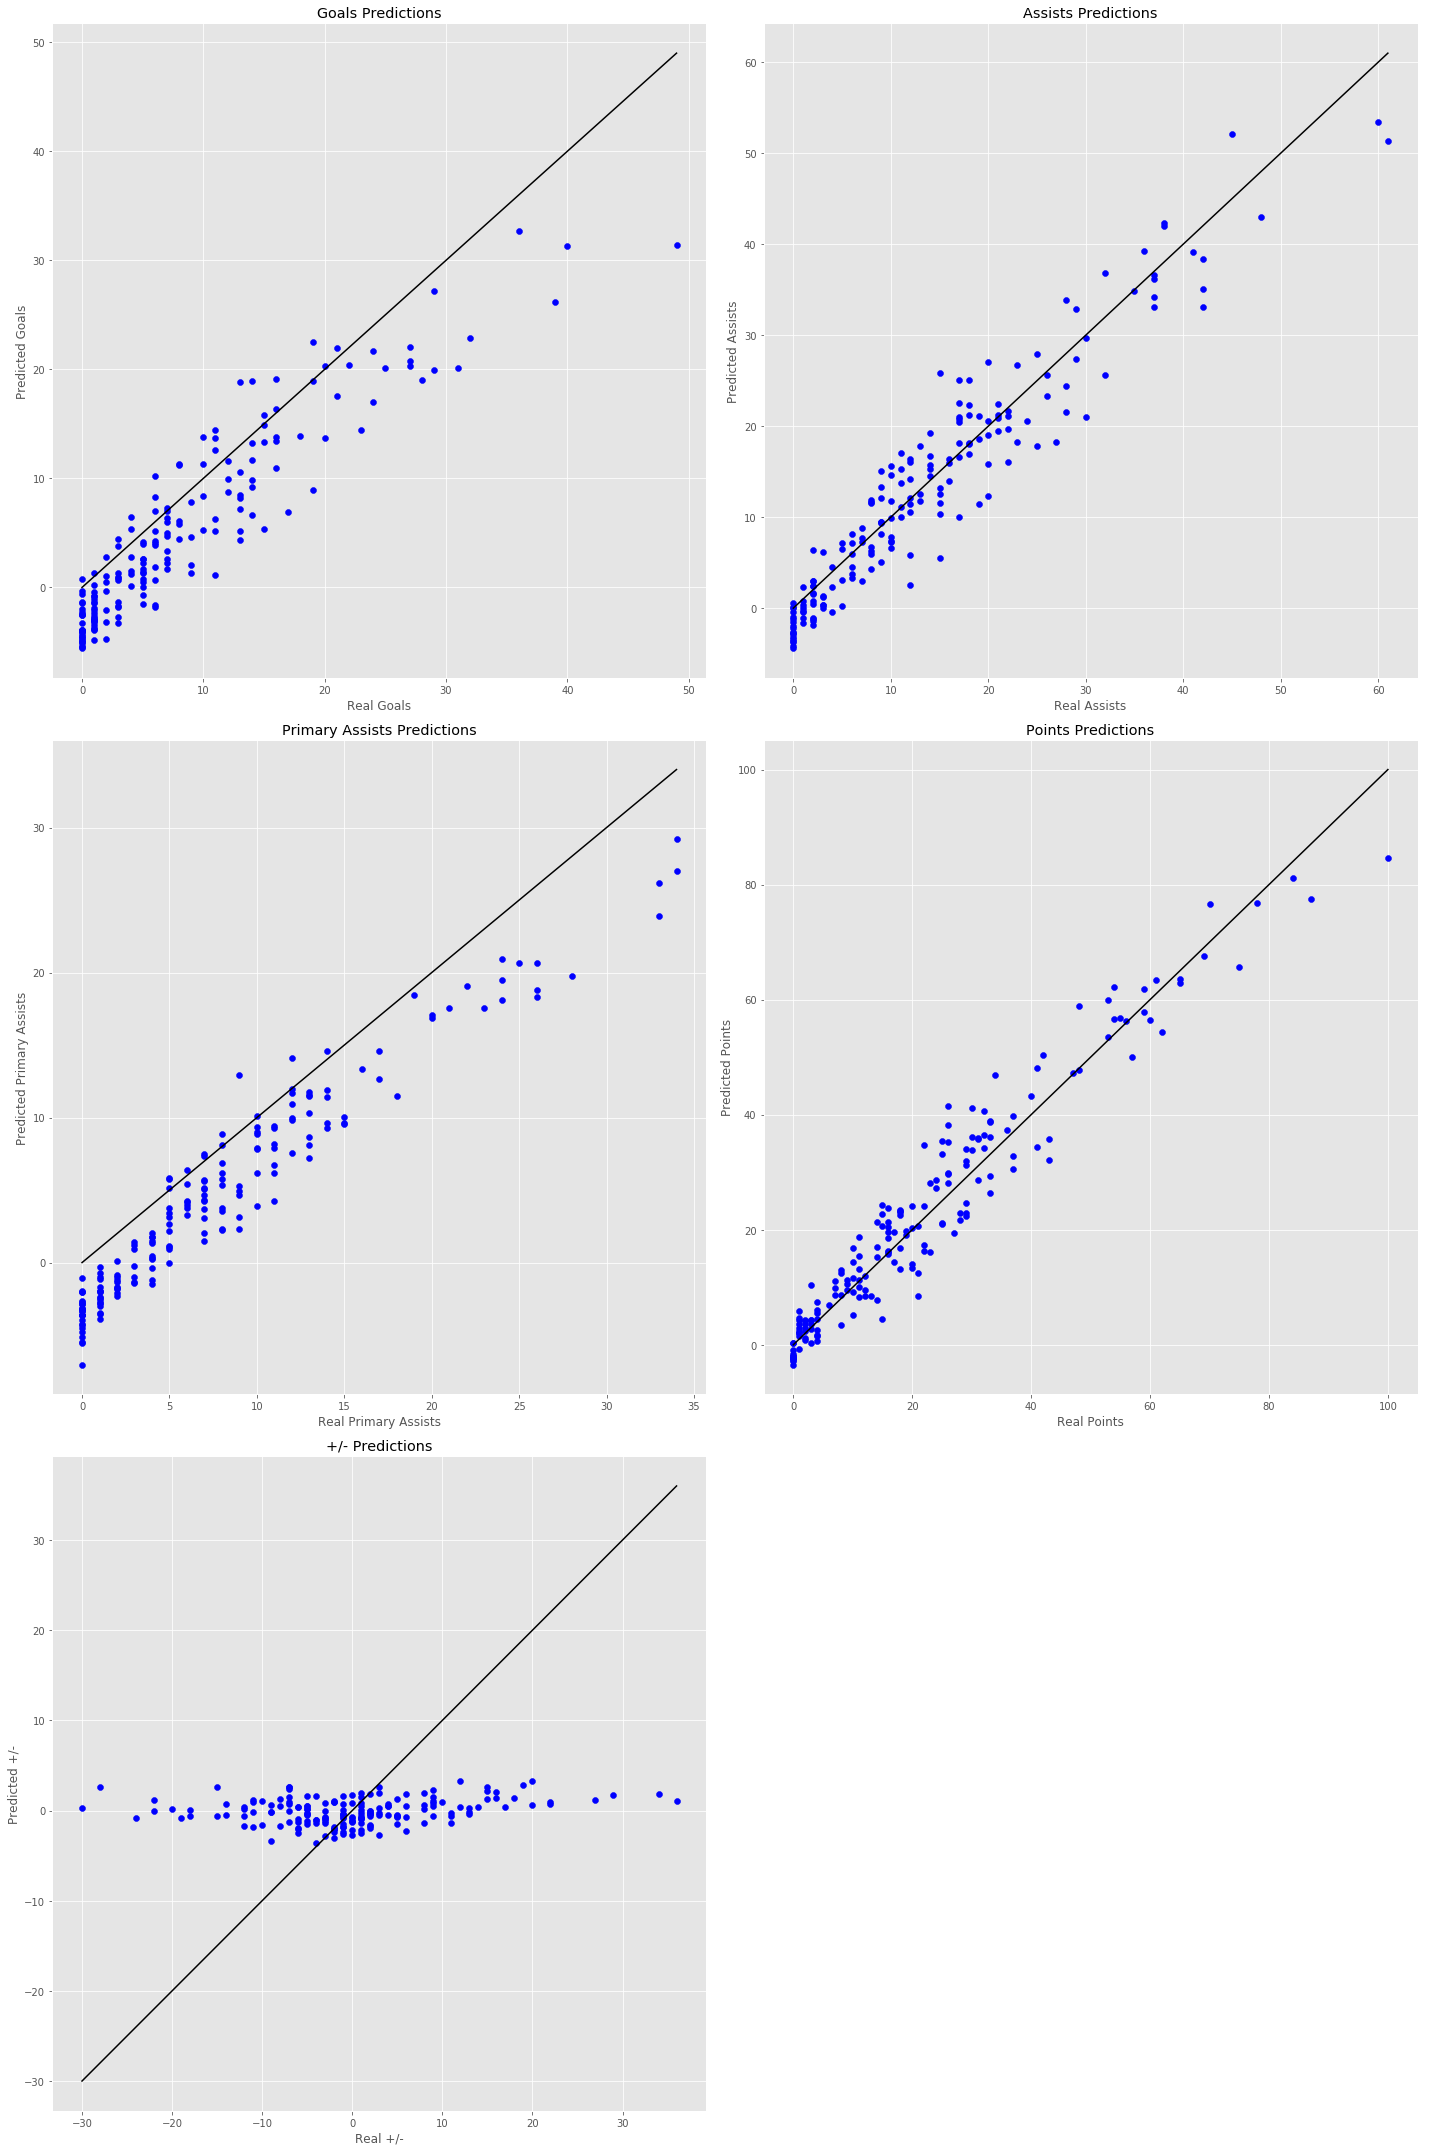

In [18]:
nepochs = 801
predictions_totales = []
for targets in [[training_targets_goals, test_targets_goals],
                [training_targets_assists, test_targets_assists],
                [training_targets_primary_assists, test_targets_primary_assists],
                [training_targets_points, test_targets_points],
                [training_targets_plusminus, test_targets_plusminus]]:
    t1 = time.time()
    loss_train, loss_valid, network = train(training_data, targets[0], nepochs)
    print("Temps d'entrainement : {}".format(time.time()-t1))
    predictions = predict(network, test_data, targets[1])
    predictions_totales.append(predictions)
    

plt.style.use('ggplot') 
fig,ax = plt.subplots(nrows=3, ncols=2, figsize = (20,30))
ax1, ax2, ax3, ax4, ax5, ax6 = ax.flatten()

ax1.scatter(test_targets_goals, predictions_totales[0], c = 'b')
ax1.plot([0,np.max(test_targets_goals)],[0,np.max(test_targets_goals)], 'k')
ax1.set_xlabel('Real Goals')
ax1.set_ylabel('Predicted Goals')
ax1.set_title('Goals Predictions')

ax2.scatter(test_targets_assists, predictions_totales[1], c = 'b')
ax2.plot([0,np.max(test_targets_assists)],[0,np.max(test_targets_assists)], 'k')
ax2.set_xlabel('Real Assists')
ax2.set_ylabel('Predicted Assists')
ax2.set_title('Assists Predictions')

ax3.scatter(test_targets_primary_assists, predictions_totales[2], c = 'b')
ax3.plot([0,np.max(test_targets_primary_assists)],[0,np.max(test_targets_primary_assists)], 'k')
ax3.set_xlabel('Real Primary Assists')
ax3.set_ylabel('Predicted Primary Assists')
ax3.set_title('Primary Assists Predictions')

ax4.scatter(test_targets_points, predictions_totales[3], c = 'b')
ax4.plot([0,np.max(test_targets_points)],[0,np.max(test_targets_points)], 'k')
ax4.set_xlabel('Real Points')
ax4.set_ylabel('Predicted Points')
ax4.set_title('Points Predictions')

ax5.scatter(test_targets_plusminus, predictions_totales[4], c = 'b')
ax5.plot([np.min(test_targets_plusminus),np.max(test_targets_plusminus)],[np.min(test_targets_plusminus),np.max(test_targets_plusminus)], 'k')
ax5.set_xlabel('Real +/-')
ax5.set_ylabel('Predicted +/-')
ax5.set_title('+/- Predictions')

ax6.axis('off')

fig.tight_layout()
plt.savefig('predictions.png')

In [20]:
pred_goals = predictions_totales[0]
pred_assists = predictions_totales[1]
pred_primary_assists = predictions_totales[2]
pred_points = predictions_totales[3]
pred_plusminus = predictions_totales[4]

In [26]:
targets_list = [test_targets_goals, test_targets_assists, test_targets_primary_assists, test_targets_points]
treshold_list = [3, 5, 3, 9]
std, deviations = [], []
for pred, target, treshold in zip(predictions_totales[:-1], targets_list, treshold_list) :
    not_small = np.where(target > treshold)[0]
    deviations.append((pred[not_small] - target[not_small]) / target[not_small])
    std.append(np.std(deviations[-1]))

In [27]:
std

[0.394513, 0.2722712, 0.2967209, 0.25777662]

In [85]:
# predictions = predict(network,training_data[train_size:], training_targets_points[train_size:])
# not_small = np.where(training_targets_points[train_size:] > 10)[0]
# deviation_points = (predictions[not_small] - training_targets_points[train_size:][not_small])/ training_targets_points[train_size:][not_small]
# print(np.std(deviation_points))

0.25144595


Text(0.5,1,'Points Predictions')

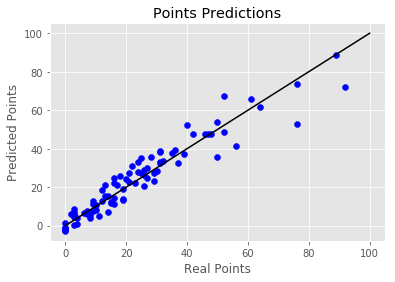

In [58]:
# fig, ax = plt.subplots()
# ax.scatter(training_targets_points[train_size:], predictions, c = 'b')
# ax.plot([0,np.max(test_targets_points)],[0,np.max(test_targets_points)], 'k')
# ax.set_xlabel('Real Points')
# ax.set_ylabel('Predicted Points')
# ax.set_title('Points Predictions')

(array([ 2.,  2.,  4.,  3.,  6., 14.,  5.,  7.,  4.,  5.,  3.,  1.,  1.,
         3.,  1.]),
 array([-0.44375786, -0.3672794 , -0.290801  , -0.21432254, -0.1378441 ,
        -0.06136566,  0.01511278,  0.09159122,  0.16806966,  0.2445481 ,
         0.32102653,  0.397505  ,  0.4739834 ,  0.5504618 ,  0.6269403 ,
         0.70341873], dtype=float32),
 <a list of 15 Patch objects>)

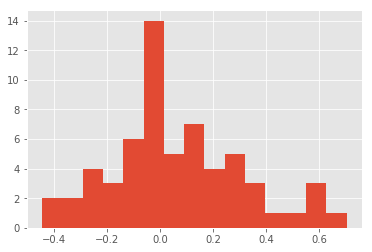

In [86]:
plt.hist(deviation_points, bins=15)